In [1]:
%%capture --no-stdout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata as ad
import cna
np.random.seed(0)

# covarying neighborhood analysis tutorial

This notebook demonstrates the basic use of the `cna` python package. Before you run it, make sure you either install `cna` by running `pip install cna` or by cloning the `cna` github repo and adding it to your python path. (In the latter case you'll likely need to manually install the `multianndata` package, which is a dependency of `cna`.)

## table of contents:
1. [minimal working example](#first-section)
1. [processing data into the correct format](#second-section)
1. Additional CNA features: [additional results produced by cna's association function](#third-section)
1. Additional CNA features: [working directly with the NAM and NAM PCs](#fourth-section)

## 1. minimal working example <a class="anchor" id="first-section"></a>

Let's run `cna` and visualize results for a toy dataset in the commonly used `AnnData` format that already has a UMAP nearest-neighbor graph. You can learn more about data pre-processing and formatting in Section 2.

### 1.1 read in data

First, we'll read in the dataset and generate some sample-level metadata from the cell-level metadata.

In [2]:
# read in data
d = ad.read_h5ad('data.h5ad')

# create sample-level metadata by combining across all cells from each sample
samplem = cna.ut.obs_to_sample(d,                           # the dataset
                               ['case','male','batch'],     # the metadata columns to use
                               'id')                        # the column of d.obs that contains sample IDs

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


### 1.2 perform case/control analysis

In [3]:
# perform association test for case/ctrl status, controlling for sex as a covariate and accounting for potential batch effect
p = cna.tl.association(d,                 #dataset
            samplem.case,                 #sample-level attribute of intest (case/control status)
            'id',                         #the column in d.obs that contains sample ids
            covs=samplem[['male']],       #covariates to control for (in this case just one)
            batches=samplem.batch,        #batch assignments for each sample so that cna can account for batch effects
            key_added='case_coef')    #label to give the results in d.obs

print('\nglobal association p-value:', p)
print((d.obs.case_coef_fdr <= 0.05).sum(), 'neighborhoods passed significance at FDR 5%')

/Users/yakir/Dropbox/py/cna/src/cna/tools/_association.py:87: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\



global association p-value: 0.000999000999000999
9551 neighborhoods passed significance at FDR 5%


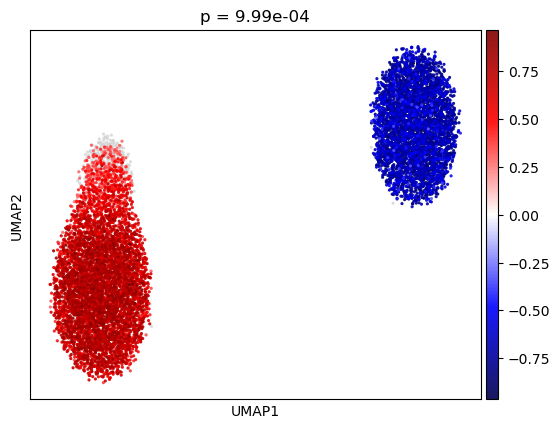

In [4]:
# visualize which populations are expanded or depleted among case samples relative to cntrls
cna.pl.umap_ncorr(d,                           #dataset
            key='case_coef',               #key in d.obs that contains the association test results
            scatter0={'s':20},                 #plotting parameters for neighborhoods that pass FDR
            scatter1={'s':20})                 #plotting parameters for neighborhoods that don't pass FDR
plt.title('p = {:.2e}'.format(p))
plt.show()

In the plot above, each cell is colored according to its neighborhood coefficient, *i.e.*, color corresponds to the correlation of abundance in each cell's corresponding neighborhood to case/control status. Neighborhoods that don't pass FDR 5% are shown in gray. As this plot shows, cases have a greater abundance of cells from the left-hand cluster relative to controls.

### 1.3 analyze a more sophisticated phenotype

Let's next perform an association test for male/female sex rather than case/control status...

/Users/yakir/Dropbox/py/cna/src/cna/tools/_association.py:87: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


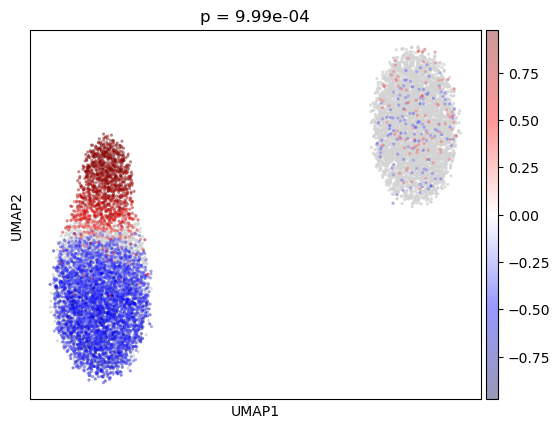

In [5]:
# perform association test for male/female sex
# we control for case/control status as a covariate and account for potential batch effects
p = cna.tl.association(d, samplem.male, 'id', covs=samplem[['case']], batches=samplem.batch, key_added='male_coef')

# visualize the results
cna.pl.umap_ncorr(d,
                  key='male_coef',
                  scatter0={'s':20},
                  scatter1={'alpha':0.4, 's':20})
plt.title('p = {:.2e}'.format(p))
plt.show()

It's now clear that a sub-population of the left-hand cluster is more abundant in males. CNA automatically picked up on this without needing to be given a resolution parameter.

Note that it looks like some cells in the right-hand cluster pass our FDR threshold of 5%. However, these cells comprise only ~6% of the cells that pass the threshold and so are likely false discoveries.

### 1.4 relate results to clusters

If this dataset had been clustered, two clusters would likely have been defined.

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_70600/19806435.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(d, resolution = 0.1)


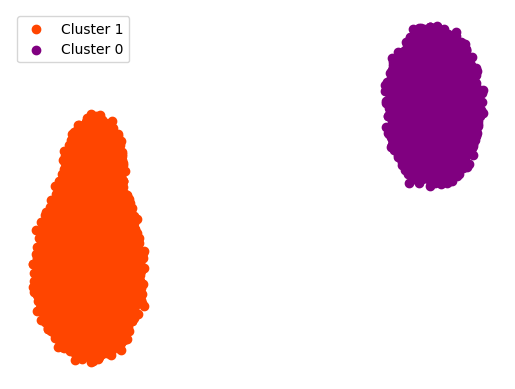

In [6]:
sc.tl.leiden(d, resolution = 0.1)
plt.scatter(*d.obsm['X_umap'][d.obs.leiden=='0'].T, c='orangered', label='Cluster 1')
plt.scatter(*d.obsm['X_umap'][d.obs.leiden=='1'].T, c='purple', label='Cluster 0')
plt.legend(); plt.axis('off')
plt.show()

We can examine within-cluster heterogeneity characterized by CNA by visualizing the distribution of neighborhood coefficients within each cluster.

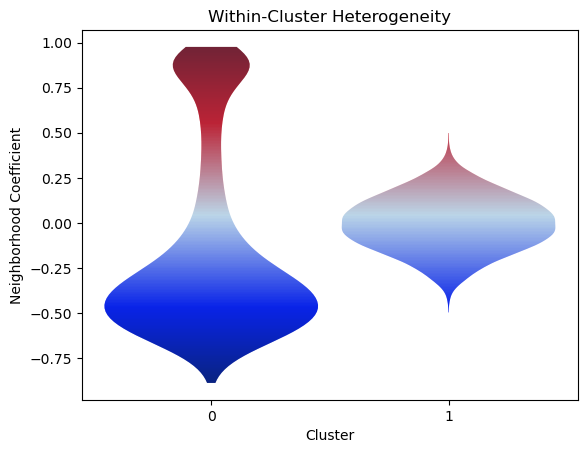

In [7]:
ax = cna.pl.violinplot(d,           # dataset
                  'leiden',         # name of the column of obs that contains the clustering
                  key='male_coef')
ax.set_title('Within-Cluster Heterogeneity')
ax.set_xlabel('Cluster')
plt.show()

### 1.5 relate results to genes

To characterize the populations driving the association, we can examine per-gene correlations to neighborhood coefficient. These per-gene values may be informative on their own, or they could be further analyzed using techniques like gene set enrichment analysis.

In [8]:
# compute correlation between neighborhood coefficients and genes
d.var['corr_case'] = np.corrcoef(d.obs.male_coef.values.reshape(1,-1), d.X, rowvar=False)[0,1:]

In [9]:
# view top 5 most strongly correlated genes
d.var.sort_values('corr_case', ascending=False).head()

,corr_case
gene,
gene_10,0.187600
gene_9,0.182945
gene_11,0.180546
gene_4,0.179860
gene_1,0.173433


In [10]:
# view top 5 most negatively correlated genes
d.var.sort_values('corr_case', ascending=True).head()

,corr_case
gene,
gene_20,-0.100975
gene_21,-0.096953
gene_22,-0.087278
gene_14,-0.085132
gene_19,-0.080161


## 2. Preprocessing <a class="anchor" id="second-section"></a>

The main pre-processing step that is required before running `cna` is to compute a cell-cell similarity graph. Here we'll use `scanpy` to compute the standard UMAP similarity graph. (In principle, any graph can be computed here.) This was already done for the saved data file used above, but if it hadn't been the workflow would have been standard:

In [11]:
%%capture --no-stdout

# compute the UMAP cell-cell similarity graph
sc.pp.neighbors(d)

# compute UMAP coordinates for plotting
sc.tl.umap(d)

# the following line would save the pre-processed data as a h5ad file
# d.write('test.h5ad')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 3. additional `cna` features

### 3.1 additional results produced by the `cna` `association` function <a class="anchor" id="third-section"></a>

Let's re-do the `cna` analysis for case status and go over the results in more detail. Here we use the arguments `show_progress=True` to provide more verbose logging information and also `return_full=True` which causes cna to return a more detailed results object.

In [12]:
# read in data
d = ad.read_h5ad('data.h5ad')

# create sample-level metadata by combining across all cells from each sample
samplem = cna.ut.obs_to_sample(d,                           # the dataset
                               ['case','male','batch'],     # the metadata columns to use
                               'id')                        # the column of d.obs that contains sample IDs

# run the analysis
res = cna.tl.association(d, samplem.case, 'id', covs=samplem[['male']], batches=samplem.batch, return_full=True)

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/Users/yakir/Dropbox/py/cna/src/cna/tools/_association.py:87: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


The `res` object returned by the association function contains the following fields:
1. `p` is the global p-value for association
1. `k` is the number of NAM PCs used for the association test (automatically selected in a data-dependent way)
1. `ncorrs` is the vector of neighborhood coefficients
1. `fdr_10p_t` and `fdr_5p_t` contain the thresholds on `np.abs(ncorrs)` needed to provide FDRs of 10% and 5% respectively
1. `fdrs` contains information on neighborhood-level FDRs at other thresholds
1. `kept` is a boolean vector that specifies which cells passed qc. So, e.g., `ncorrs` is of length `kept.sum()`.
1. `r2` is the global prediction r-squared achieved by the model
1. `r2_perpc` is the prediction r-squared achieved by each pc on its own
1. `beta` is the coefficient vector, one coefficient per PC
1. `yresid` and `yresid_hat` are the phenotype and the predicted phenotype, both with covariates and batch residualized out

The kurtosis numbers in the output above say how 'outlier-y' the neighborhood abundances are at each step in the diffusion that `cna` does to define its neighborhoods. The algorithm stops when these numbers stop going down quickly. But if you see that `cna` stops when kurtosis is still very high (like above 10), that's likely a sign that the data aren't qc'd properly or are otherwise unsuitable.

### 3.2 working directly with the NAM and NAM PCs <a class="anchor" id="fourth-section"></a>

The association function above also automatically computes the NAM and its SVD as a prerequisite to the association testing. These can be found in the following objects
1. `res.nam` contains the NAM (before any covariate correction)
1. `res.namresid` contains the NAM after batch and covariates have been residualized out
1. `res.namresid_sampleXpc` contains the sample loadings of the principal components of the residualized NAM
1. `res.NAM_nbhdXpc` contains the neighborhood loadings of the principal components of the residaulized NAM
1. `res.NAM_svs` contains the squared singular values of the residualized NAM

The NAM raw NAM can also be computed independent of any association test using the function `cna.tl.nam`, demonstrated below

In [13]:
nam, kept = cna.tl.nam(d, 'id', batches=samplem.batch)  #note: this NAM is being computed *without* adjusting for sex or case/ctrl status
                                                        # the kept object lists which cells' neighborhoods passed QC and are retained in the NAM
U, svs, V = cna.tl.svd_nam(nam)

Let's visualize a few of the results...

#### 3.2.1 neighborhood loadings of NAM PCs

First, we can plot the neighborhood loadings of each NAM PC to see which abundance patterns they capture

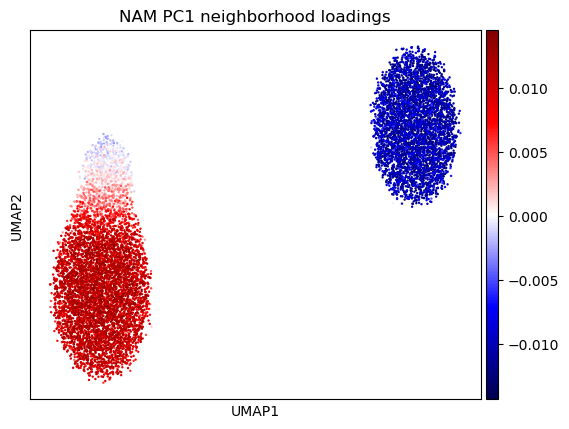

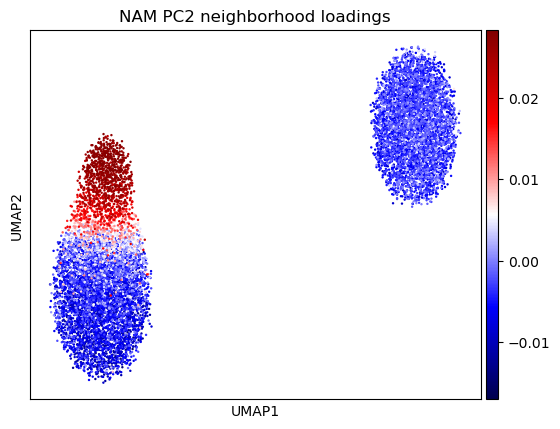

In [14]:
#plot neighborhood loadings of NAM PC 1
d.obs.loc[kept, 'NAMPC1'] = V.PC1
sc.pl.umap(d, color='NAMPC1', cmap='seismic', title='NAM PC1 neighborhood loadings')
plt.show()

# #plot neighborhood loadings of NAM PC 2
d.obs.loc[kept, 'NAMPC2'] = V.PC2
sc.pl.umap(d, color='NAMPC2', cmap='seismic', title='NAM PC2 neighborhood loadings')
plt.show()

We can see here that NAM PC 1 primarily captures the extent to which a sample has cells in the left-hand cluster vs the right-hand cluster, and that NAM PC 2 primarily additionall captures the extent to which a sample has cells in the top of the left-hand cluster vs the bottom of the left-hand cluster.

#### 3.2.2 sample loadings of NAM PCs

We can also examine the sample loadings of each NAM PC to explicitly see which samples have high and low values of each NAM PC. Below we'll examine how this relates to the sample-level metadata in our toy dataset.

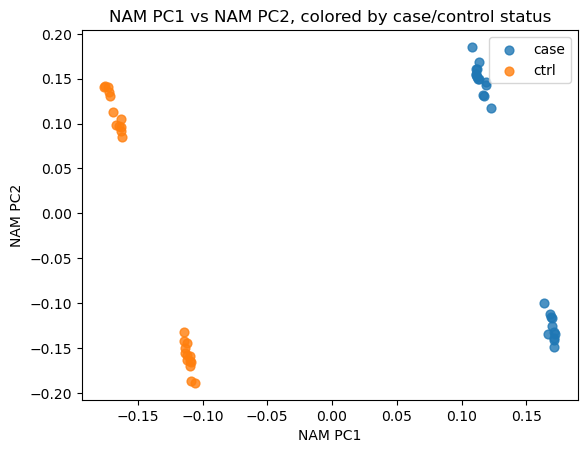

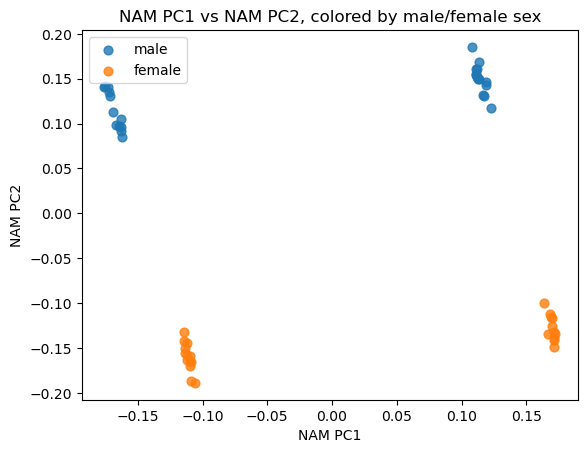

In [15]:
def sample_loading_plot_by_binary_pheno(pheno, case_label, ctrl_label): #assumes pheno is binary
    cases = pheno.astype('bool')
    plt.scatter(U.loc[cases].PC1, U.loc[cases].PC2, s=40, alpha=0.8, label=case_label)
    plt.scatter(U.loc[~cases].PC1, U.loc[~cases].PC2, s=40, alpha=0.8, label=ctrl_label)
    plt.legend()
    plt.xlabel('NAM PC1')
    plt.ylabel('NAM PC2')

#plot sample loadings of NAM PC1 versus NAM PC2, colored by case/control status
sample_loading_plot_by_binary_pheno(samplem.case, 'case', 'ctrl')
plt.title('NAM PC1 vs NAM PC2, colored by case/control status')
plt.show()

#plot sample loadings of NAM PC1 versus NAM PC2, colored by male/female sex
sample_loading_plot_by_binary_pheno(samplem.male, 'male', 'female')
plt.title('NAM PC1 vs NAM PC2, colored by male/female sex')
plt.show()

You can see in these plots that NAM PC 1 roughly corresponds to case/control status and NAM PC1 roughly corresponds to sex.

#### 3.2.3 variance explained by NAM PCs

Like ordinary PCs, each NAM PC also comes with a quantification of how much dataset-wide variance it explains. These are stored in the `NAM_svs` field. Let's visualize them in the traditional way below.

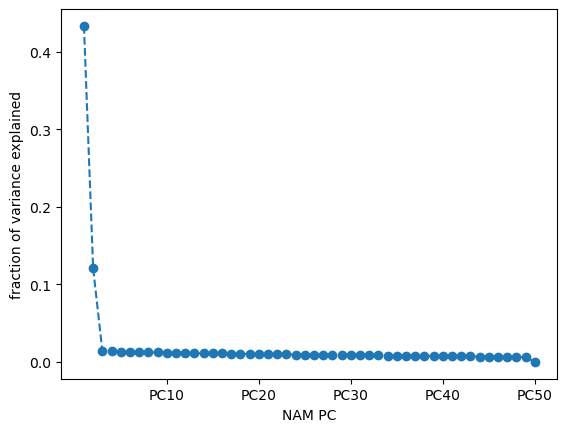

In [16]:
# plot variance explained by each NAM PC
plt.plot(svs/svs.sum(), marker='o', linestyle='--')
plt.xlabel('NAM PC')
plt.ylabel('fraction of variance explained')
plt.xticks([9, 19, 29, 39, 49])
plt.show()

As this plot demonstrates, PC1 explains ~40% of the variance in the dataset, PC2 explains ~12%, and the rest really don't contribute much.